# Observation Targets Assessor
This notebook aims to injest a list of source descriptions and observation criteria from the STM effort, applying appropriate metric tools to assess against the critera for a list of mission concept descriptions.

To run this on Google Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/binaryResolutionSources.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
!mkdir -p '../plots/'

# Import
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(src)
import constants
import metrics
import sources
import concepts
import subsystems
import background
import pandas as pd
from glob import glob
import re
from astropy.coordinates import Angle
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u

### Define the set of concepts
Here we load in a set of the pre-defined concepts, or you can define your own

In [2]:
missionNames = (
    'LISACBE',
    'LISASciRDv1',
    'TwinLISA',
    'LISAGrande',
    'LISAU',
    'GoBIGLISA',
    'ALIA',
    'ALIAlowL')
missions=[concepts.menu[mission] for mission in missionNames]

for mission in missions:
    mission=background.add2model(mission)
#model = concepts.LISACBE.copy()
#modelName = model.get('label')
#model = background.add2model(model)     # add galactic background model

### Load the observation target data
Load information about the target sources and the observation quality targets from the STM.
The data are from https://nasa.sharepoint.com/:x:/t/GravitationalWaveImager/EaaeMC7L-2NJpFCQloYbSnoBDZag_cvFWR5_BjRoFAD6Tw?e=uWr4mU

In [3]:
file=glob('../Data/ObservationObjectives*.csv')[0]
print('Observation targets file is:',file)
#Read file
df=pd.read_csv(file,header=1)
print(len(df),'rows read from file.')
if True:
    #Drop empty rows
    for i,row in df.iterrows():
        if row.isnull().all():
            df=df.drop(i)
    #Fill empties in first column with values above
    val=float('nan')
    col='Source class'
    for i,row in df.iterrows():
        if row.isnull()[col]:
            df.loc[i,col]=val
        else:
            val=df.loc[i,col]
#Drop rows without a labeled objective
for i,row in df.iterrows():
    if row.isnull()['provisional POC label']:
        df=df.drop(i)
print(len(df),'rows with a potential observation label.')
#Fill empties with value above
if True:
    for columnName, columnData in df.iteritems():
        val=float('nan')
        nulls=columnData.isnull()
        for i,row in df.iterrows():
            if nulls[i]:
                df.loc[i,columnName]=val
            else:
                val=df.loc[i,columnName]
#derive masses
if True:
    col=2
    df['m1']=float('nan')
    df['m2']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        mtxt=re.search('\s*Msun\s*\+\s*.*Msun',txt)
        #print('::',mtxt)
        mtxt=re.search('(\d+\.*\d*[eE]*[\+-]*\d*)\s*M[Ss]un\s*\+\s*(\d+\.*\d*[eE]*[\+-]*\d*)\s*M[Ss]un',txt)
        #print(':',mtxt)
        m1=None
        if mtxt is not None: 
            try:
                m1=float(mtxt[1])
                #print(m1)
                m2=float(mtxt[2])
                #print(m2)
            except: 
                pass
        if m1 is None:
            df=df.drop(i)
        else:
            df.loc[i,'m1']=m1
            df.loc[i,'m2']=m2
    print(len(df),'rows with masses.')
#derive redshifts/distances
if True:
    col=3
    df['z']=float('nan')
    df['dist']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        ztxt=re.search('z\s*=\s*(\d+\.*\d*[eE]*[\+-]*\d*)',txt)
        z=None
        if ztxt is not None: 
            try:
                z=float(ztxt[1])
                dist=cosmo.luminosity_distance(z).to(u.kpc).value
            except: 
                pass
        if z is None:
            df=df.drop(i)
        else:
            df.loc[i,'z']=z
            df.loc[i,'dist']=dist
    print(len(df),'rows with redshift.')
#derive timecuts
if True:
    col=4
    df['timecut']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        ztxt=re.search('(.*)\s+(before|<)\s+merger',txt)
        z=None
        if ztxt is not None:
            try:
                ztxt=ztxt[1]
                if ztxt=='month to week': z=15
                elif ztxt=='year to month': z=180
            except: 
                pass
        df.loc[i,'timecut']=z
#derive SNRs
if True:
    col=4
    df['SNR']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        ztxt=re.search('SNR\s*=\s*(\d+\.*\d*[eE]*[\+-]*\d*)',txt)
        z=None
        if ztxt is not None: 
            try:
                z=float(ztxt[1])
            except: 
                pass
        df.loc[i,'SNR']=z
#prep CW sources
if True:
    col=0
    df['CW']=False
    df['f0']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        if 'Persistent' in txt: 
            df.loc[i,'CW']=True
            #Also need to f0 (or separation)
            txt=row['freq']
            try:
                ftxt=re.search('(\d+\.*\d*[eE]*[\+-]*\d*)\s+Hz',txt)[1]
                f0=float(ftxt)
                df.loc[i,'f0']=f0
            except:
                print('Failed to get freq from txt "'+txt+'"')
                df=df.drop(i)
#process angular precision
if True:
    col=6
    df['resolution']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        z=None
        #print(txt)
        try:
            #print(Angle(txt))
            z=Angle(txt).arcsecond
        except: 
            pass
        df.loc[i,'resolution']=z
#Drop cases with neither angular precision requirement nor SNR
for i,row in df.iterrows():
    if np.isnan(row['resolution']) and np.isnan(row['SNR']):df=df.drop(i)
print(len(df),'rows with constraints.')        
display(df)


Observation targets file is: ../Data/ObservationObjectives-9-May-22.csv
110 rows read from file.
54 rows with a potential observation label.
51 rows with masses.
48 rows with redshift.
42 rows with constraints.


,Source class,Source label,Source specification,Distance/redshift (dL in kpc),Sub-specs,freq,Required precision,provisional POC label,Achievable by Concept X?,science motivation,sci ref,m1,m2,z,dist,timecut,SNR,CW,f0,resolution
1,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 0.05; dL = 2.30e5,month to week before merger,0.5 Hz,1 arcmin,1.1.b,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,1.5,0.050000,2.245822e+05,15.0,NaN,False,NaN,60.0
2,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 1.0; dL = 6.79e6,chirping,0.5 Hz,30 arcsec,1.1.c,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,1.5,1.000000,6.726141e+06,NaN,NaN,False,NaN,30.0
3,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 20; dL = 2.31e8,chirping,0.5 Hz,6 arcsec,1.1.d,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,1.5,20.000000,2.316106e+08,NaN,NaN,False,NaN,6.0
4,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 10; dL = 1.07e8,chirping,0.5 Hz,1 arcsec,1.1.e,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,1.5,10.000000,1.065544e+08,NaN,NaN,False,NaN,1.0
6,1. Stellar-scale mergers,NS-BH binary,1.5 MSun + 10 MSun,z = 0.2; dL = 1.01e6,month to week before merger,0.29 Hz,1 arcmin,1.2.b,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,10.0,0.200000,9.916448e+05,15.0,NaN,False,NaN,60.0
8,1. Stellar-scale mergers,BH binary,30 MSun + 30 MSun,z = 0.2; dL = 1.01e6,month to week before merger,0.11 Hz,1 arcmin,1.3.b,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,30.0,30.0,0.200000,9.916448e+05,15.0,NaN,False,NaN,60.0
10,1. Stellar-scale mergers,BH binary,30 MSun + 30 MSun,z = 1.0; dL = 6.79e6,chirping,0.11 Hz,30 arcsec,1.3.c,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,30.0,30.0,1.000000,6.726141e+06,NaN,NaN,False,NaN,30.0
11,1. Stellar-scale mergers,BH binary,30 MSun + 30 MSun,z = 20; dL = 2.31e8,chirping,0.11 Hz,6 arcsec,1.3.d,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,30.0,30.0,20.000000,2.316106e+08,NaN,NaN,False,NaN,6.0
12,1. Stellar-scale mergers,BH binary,30 MSun + 30 MSun,z = 10; dL = 1.07e8,chirping,0.11 Hz,1 arcsec,1.3.e,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,30.0,30.0,10.000000,1.065544e+08,NaN,NaN,False,NaN,1.0
16,2.MBHB,MBH binary,1e6 MSun + 1e6 MSun,z = 1.0; dL = 6.79e6,year to month before merger,3e-5 Hz,1 arcmin,2.1.b,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1000000.0,1000000.0,1.000000,6.726141e+06,180.0,NaN,False,NaN,60.0


In [4]:
# make source dictionaries
objectiveList=[]
minimumSNR=5
for i,row in df.iterrows():
    obj={}
    obj['label']=row['provisional POC label']
    obj['m1']=row['m1']
    obj['m2']=row['m2']
    dist=cosmo.luminosity_distance(row['z']).to(u.kpc).value
    obj['dl']=dist
    if row['CW']:
        obj['type']='CW'
        obj['f0']=row['f0']
    else:
        obj['type']='chirp'
        if np.isfinite(row['timecut']):
            obj['timecut']=row['timecut']
    #Now add the conditions
    conditions={}
    if np.isfinite(row['resolution']):
        conditions['resolution']=row['resolution']
    snr=minimumSNR
    if np.isfinite(row['SNR']): snr=max([minimumSNR,row['SNR']])
    conditions['SNR']=snr
    obj['conditions']=conditions
    objectiveList.append(obj)
    

### Perform the observations and assessment
We first compute the SNR and then the angular resolution

In [5]:

for mission in missions:
    obs = list()
    for s in objectiveList:
        ob = metrics.getSourceSnr(s,mission,-4.0*constants.year)
        ob = metrics.getResolution(ob)
        #Perform the assessment
        #The assessment is based on the ratio of the estimated capability to the objective for each of
        #resolution and SNR, with <=1 meaning that the objective is met
        #A total is based on the worst of those present
        conditions=s['conditions']
        assessment={}
        alleps=[]
        print(conditions)
        if 'SNR' in conditions:
            eps=conditions['SNR']/ob['SNR']
            assessment['eps_SNR']=eps
            alleps.append(eps)
        if 'resolution' in conditions:
            eps=ob['Angular Resolution'][-1]/conditions['resolution']
            #print(ob['Angular Resolution'][-1],conditions['resolution'],eps)
            assessment['eps_res']=eps
            alleps.append(eps)
        #print('alleps',alleps)
        if len(alleps)>0: assessment['eps']=max(alleps)
        ob['assessment']=assessment    
        obs.append(ob)
        
    mission['obs']=obs
    


QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 60.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 30.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 6.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 1.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 60.0, 'SNR': 5}
QE: 0.8

/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:168: RuntimeWarning: invalid value encountered in log10
  tvals = -np.flip(np.logspace(np.log10(-tstop),np.log10(-tstart),Npts))
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/PhenomWaveform_nonspinning.py:158: RuntimeWarning: invalid value encountered in power
  omegavals = (xvals**1.5)/M
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:177: RuntimeWarning: invalid value encountered in sqrt
  snrt = np.sqrt(np.cumsum(np.diff(fvals)*snri[1:]))
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:157: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rho2)


QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 180.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 180.0, 'SNR': 100.0}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 180.0, 'SNR': 100.0}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 180.0, 'SNR': 100.0}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 180.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 180.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217

QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 600.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 600.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 600.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 600.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 600.0, 'SNR': 5}


QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
{'resolution': 30.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
{'resolution': 6.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
{'resolution': 1.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
{'resolution': 60.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
{'resolution': 60.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
QE: 0.5

{'resolution': 60.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
{'resolution': 180.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
{'resolution': 180.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
{'resolution': 180.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
{'resolution': 180.0, 'SNR': 5}
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.173509387370

QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
{'resolution': 1.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
{'resolution': 60.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
{'resolution': 30.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
{'resolution': 6.0, 'SNR': 5}
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14
{'resolution': 1.0, 'SNR': 5}
QE: 0.81

### Show assessments

In [33]:
#Make a dataframe with the results
objectiveNames=df['provisional POC label'].values
data=np.zeros((len(obs),len(missions)))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps',None)

adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=missionNames)
#adf=adf.dropna()
def shrink():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")])
]
def zoom():
    return [
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn_r').set_properties(**{'max-width': '120px', 'font-size': '6pt'})
#s=s.set_table_styles(shrink())
s=s.set_table_styles(shrink()+zoom())
display(s)

,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL
1.1.b,100.116729,144.744416,70.793218,116.516630,382.046847,104.201593,6.032851,6.037325
1.1.c,2998.453064,4335.033157,2120.226495,3489.623062,11442.139124,3120.793003,180.681304,180.815292
1.1.d,103249.931465,149274.264663,73008.726696,120163.075501,394003.192659,107462.633806,6221.652243,6226.266059
1.1.e,47500.987825,68674.864262,33588.270604,55282.020098,181264.438553,49439.076498,2862.322747,2864.445371
1.2.b,88.611991,128.111303,62.658140,100.711503,330.139421,90.611914,6.724975,6.729885
1.3.b,2.237943,3.235253,1.582465,1.879807,6.130034,1.874454,0.349086,0.348652
1.3.c,15.179550,21.944114,10.733563,12.750378,41.578871,12.714068,2.367783,2.364842
1.3.d,522.698705,755.632394,369.603799,439.051596,1431.743468,437.801317,81.533193,81.431915
1.3.e,240.471877,347.634954,170.039295,201.989330,658.685464,201.414129,37.510022,37.463428
2.1.b,0.000516,0.000669,0.000365,0.000094,0.000084,0.000246,0.000236,0.000210


### Make some plots

#### Plot sensitivity curves and waveform
Here we scale the waveform by delta-f, which is probably not quite right

QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 1.3031119162595927e-10
sqSn_shot: 7.038237778863639e-12
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14


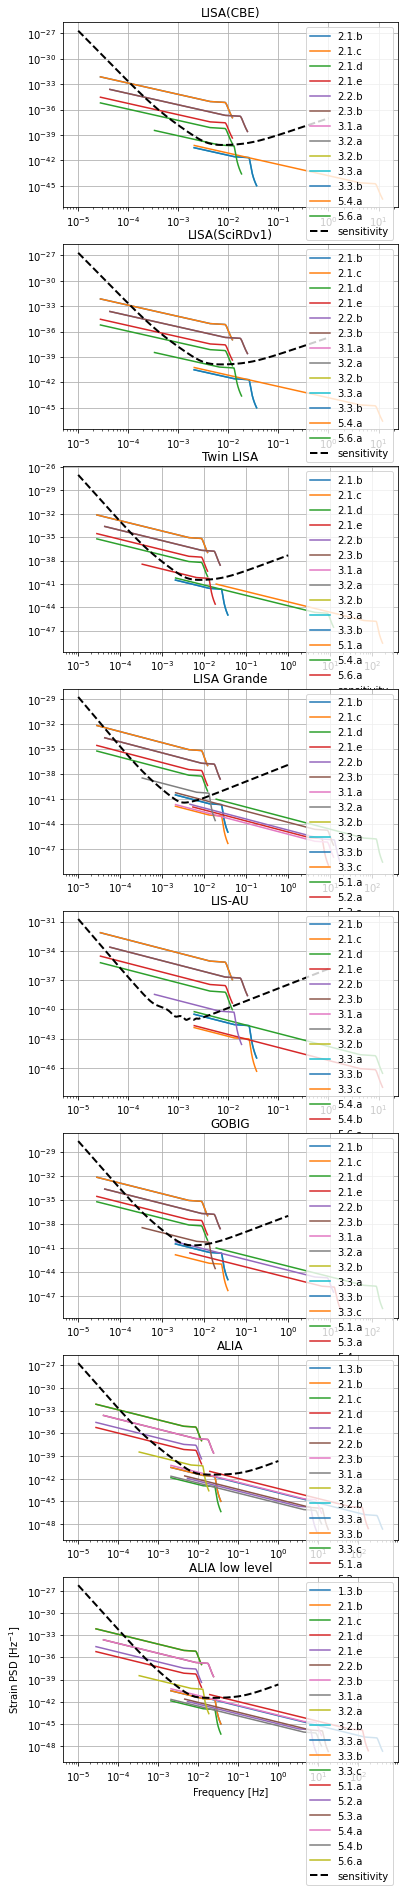

In [7]:
# sensitivity plot
#fig = plt.figure(figsize=(6,4),dpi=200)
f = np.logspace(-5,0,1000)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        ax.plot(ob.get('f')[1:],np.abs(ob.get('h')[1:]**2)*np.diff(ob.get('f')),linestyle='-',label=ob.get('source').get('label'))
    
    ax.plot(f,metrics.makeSensitivity(f,mission),color = 'black', linewidth=2.0,linestyle='--',label='sensitivity')
    ax.set_title(mission['label'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain PSD [Hz$^{-1}$]')
plt.subplots_adjust()
plt.savefig('../plots/%s_source_sensitvities.png' % 'all')

# Stuff from below here could be adapted from binaryResolutionSources, but has not been.

#### SNR as a function of time plot

#### Angular resolution as a function of time

### Make a table of the results